In [ ]:
################################################################################
# 1) Mount Drive, Check GPU, and Check RAM
################################################################################

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Check GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if 'failed' in gpu_info:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue Mar 25 07:57:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             36W /   70W |    7286MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f'Your runtime has {ram_gb:.1f} gigabytes of available RAM\n')
if ram_gb < 20:
    print('Not using a high-RAM runtime.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime.


In [ ]:
################################################################################
# 2) Installs (if needed; adjust packages as necessary)
################################################################################

!pip -qqq install pydub
!pip -qqq install tensorboard
!pip -qqq install visualkeras
!pip -qqq install --upgrade keras
!pip -qqq install --upgrade tensorflow

In [ ]:
################################################################################
# 3) Imports
################################################################################

import os
import math
import numpy as np
import librosa
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import random

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Audio
from IPython.display import Audio
from scipy.io import wavfile
import scipy
import soundfile as sf
from pydub import AudioSegment

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

# Visualization
import visualkeras


In [ ]:
################################################################################
# 4) Define Base Directories
################################################################################

base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
image_dir = os.path.join(base_dir, 'Mel_Images_1_Sec')
train_dir = os.path.join(image_dir, 'Train/Sounds')
test_dir = os.path.join(image_dir, 'Test/Sounds')

# Check if the directories exist
if not os.path.exists(train_dir):
    print(f"Train directory does not exist: {train_dir}")
if not os.path.exists(test_dir):
    print(f"Test directory does not exist: {test_dir}")

# List some files to confirm
print("Listing some files in train_dir:", os.listdir(train_dir)[:10])
print("Listing some files in test_dir:", os.listdir(test_dir)[:10])

Listing some files in train_dir: ['Explosion', 'Emergency_alarm', 'Gun_Shots', 'glass_breaking', 'thunderstorm', 'dog', 'wind']
Listing some files in test_dir: ['Gun_Shots', 'Emergency_alarm', 'Explosion', 'dog', 'glass_breaking', 'thunderstorm', 'wind']


In [ ]:
################################################################################
# 5) Data Generators
################################################################################

# You can adjust your augmentations here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
height = 128
width = 128   # Typically you'd want your spectrogram images to have a consistent shape
channels = 3  # 3 if color images

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Found {train_generator.samples} images for training.")
print(f"Found {test_generator.samples} images for testing.")

Found 1111 images belonging to 7 classes.
Found 477 images belonging to 7 classes.
Found 1111 images for training.
Found 477 images for testing.


In [ ]:
################################################################################
# 6) Define a Custom F1 Metric (Optional)
################################################################################

import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Precision, Recall

def f1_score_metric(y_true, y_pred):
    """Compute F1 using precision and recall at the batch level."""
    # Round predictions
    y_pred = K.round(y_pred)

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

In [ ]:
################################################################################
# 7) Load Pretrained VGG19 (with Frozen Layers)
################################################################################

# Include top=False means we remove the final dense layers,
# so we can replace them for our own classification.
vgg = VGG19(
    input_shape=(height, width, channels),
    weights="imagenet",
    include_top=False
)

# Freeze pretrained layers
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,081,735 (76.61 MB)

 Trainable params: 57,351 (224.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


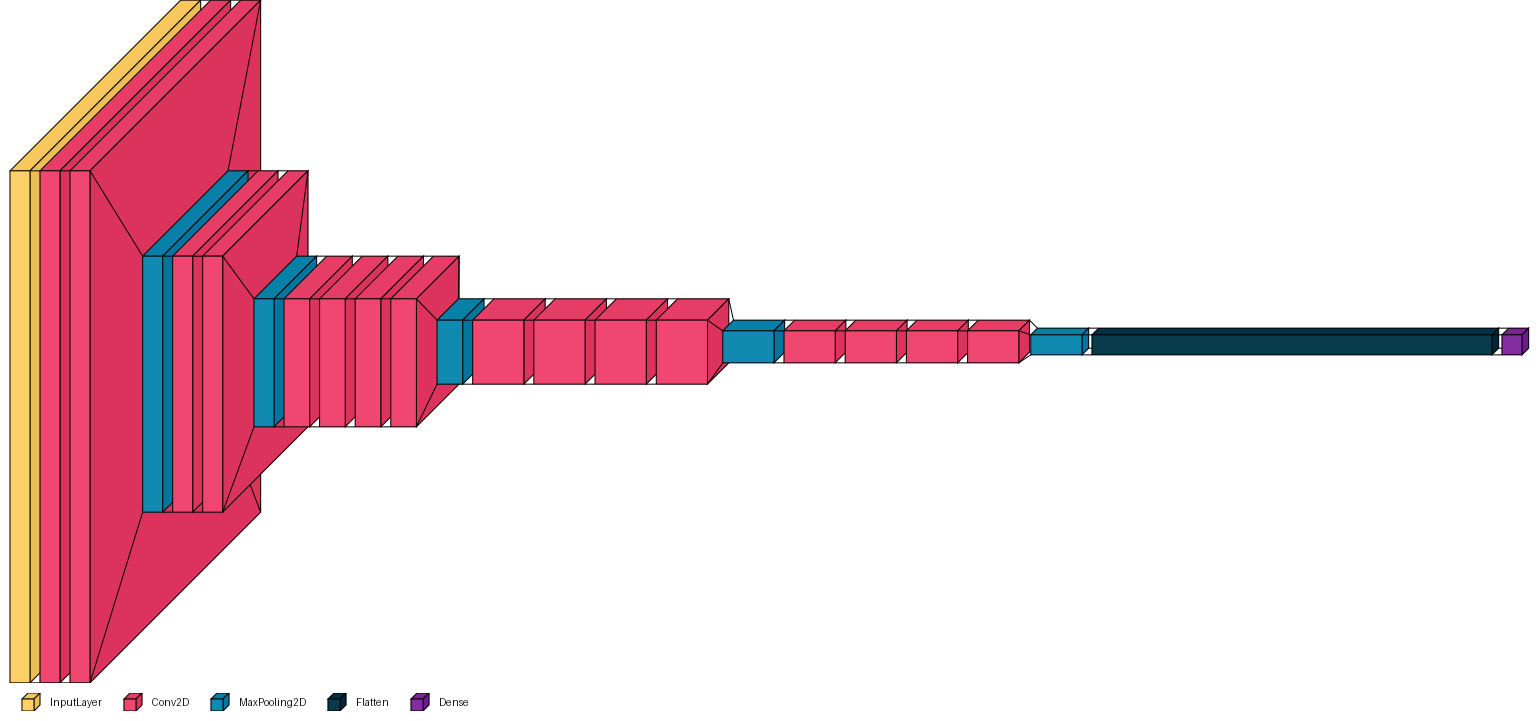

In [ ]:
################################################################################
# 8) Visualize Model
################################################################################

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)
visualkeras.layered_view(model, legend=True)  # Only works in certain environments


In [ ]:
!pip install visualkeras --upgrade
import visualkeras
# Check for 'version' instead of '__version__'
try:
    print(visualkeras.version)
except AttributeError:
    print("Version information not found. Ensure 'visualkeras' is installed correctly.")

Version information not found. Ensure 'visualkeras' is installed correctly.


In [ ]:
################################################################################
# 9) Compile the Model
################################################################################

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        f1_score_metric  # our custom F1
    ]
)


In [ ]:
################################################################################
# 10) Fit the Model (Single Training Loop)
################################################################################

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode="min",
    patience=30,
    restore_best_weights=True
)

epochs = 100  # Adjust as needed

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[early_stopping],
    shuffle=True
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2927 - f1_score_metric: 0.0746 - loss: 1.7905 - precision: 0.5977 - recall: 0.0868 - val_accuracy: 0.5681 - val_f1_score_metric: 0.0921 - val_loss: 1.1743 - val_precision: 0.7605 - val_recall: 0.3795
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 709ms/step - accuracy: 0.6007 - f1_score_metric: 0.3579 - loss: 1.1191 - precision: 0.8347 - recall: 0.3591 - val_accuracy: 0.6583 - val_f1_score_metric: 0.1139 - val_loss: 1.0345 - val_precision: 0.7437 - val_recall: 0.4990
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 722ms/step - accuracy: 0.6656 - f1_score_metric: 0.4984 - loss: 0.9588 - precision: 0.8019 - recall: 0.4846 - val_accuracy: 0.6164 - val_f1_score_metric: 0.1128 - val_loss: 0.9386 - val_precision: 0.7531 - val_recall: 0.5052
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 690ms/step - accuracy: 0.6935 - f1_score_metric: 0.5354 - loss: 0.8858 - precision: 0.8158 - recall: 0.5280 - val_accuracy: 0.7044 - val_f1_score_metric: 0.

In [ ]:
################################################################################
# 11) Evaluate & Save
################################################################################

# Evaluate on the test set
scores = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")
print(f"Test Precision: {scores[2]:.4f}")
print(f"Test Recall: {scores[3]:.4f}")
print(f"Test F1: {scores[4]:.4f}")

# (Optional) Generate a classification report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Save the model
save_path = '/content/drive/MyDrive/VGG19/MEL_Folder/al-emadi_vgg19_standardized_Mel_1_test.keras'
model.save(save_path)
print(f"Model saved to: {save_path}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 657ms/step - accuracy: 0.8363 - f1_score_metric: 0.1526 - loss: 0.4797 - precision: 0.8861 - recall: 0.7749
Test Loss: 0.5381
Test Accuracy: 0.8302
Test Precision: 0.8753
Test Recall: 0.7358
Test F1: 0.1583
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 907ms/step
                 precision    recall  f1-score   support

Emergency_alarm       0.91      0.90      0.90       124
      Explosion       0.75      0.68      0.71        78
      Gun_Shots       0.92      0.94      0.93        35
            dog       0.96      0.82      0.88        56
 glass_breaking       0.79      0.90      0.84        60
   thunderstorm       0.73      0.78      0.75        58
           wind       0.77      0.82      0.79        66

       accuracy                           0.83       477
      macro avg       0.83      0.83      0.83       477
   weighted avg       0.83      0.83      0.83       477

Model saved to: /content/drive/MyDrive/VGG19/MEL_Folder/al-emadi_vgg19_standardized_Mel_1_

In [ ]:
################################################################################
# 12) MAKE PREDICTIONS & CONFUSION MATRIX
################################################################################

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 763ms/step

Confusion Matrix:
[[111   5   0   0   3   2   3]
 [  4  53   1   0   6   8   6]
 [  1   1  33   0   0   0   0]
 [  2   0   0  46   5   2   1]
 [  2   1   2   1  54   0   0]
 [  0   6   0   1   0  45   6]
 [  2   5   0   0   0   5  54]]

Classification Report:
                 precision    recall  f1-score   support

Emergency_alarm       0.91      0.90      0.90       124
      Explosion       0.75      0.68      0.71        78
      Gun_Shots       0.92      0.94      0.93        35
            dog       0.96      0.82      0.88        56
 glass_breaking       0.79      0.90      0.84        60
   thunderstorm       0.73      0.78      0.75        58
           wind       0.77      0.82      0.79        66

       accuracy                           0.83       477
      macro avg       0.83      0.83      0.83       477
   weighted avg       0.83      0.83      0.83       477



In [ ]:
################################################################################
# 13) PER-CLASS ACCURACY
################################################################################

class_accuracy = {}
for i, lbl in enumerate(class_labels):
    correct_indices = np.where(true_classes == i)[0]
    correct_count = np.sum(predicted_classes[correct_indices] == i)
    total_count = len(correct_indices)
    if total_count > 0:
        class_accuracy[lbl] = correct_count / total_count
    else:
        class_accuracy[lbl] = 0.0

print("\nAccuracy for each class:")
for lbl in class_labels:
    print(f"{lbl}: {class_accuracy[lbl]:.4f}")



Accuracy for each class:
Emergency_alarm: 0.8952
Explosion: 0.6795
Gun_Shots: 0.9429
dog: 0.8214
glass_breaking: 0.9000
thunderstorm: 0.7759
wind: 0.8182


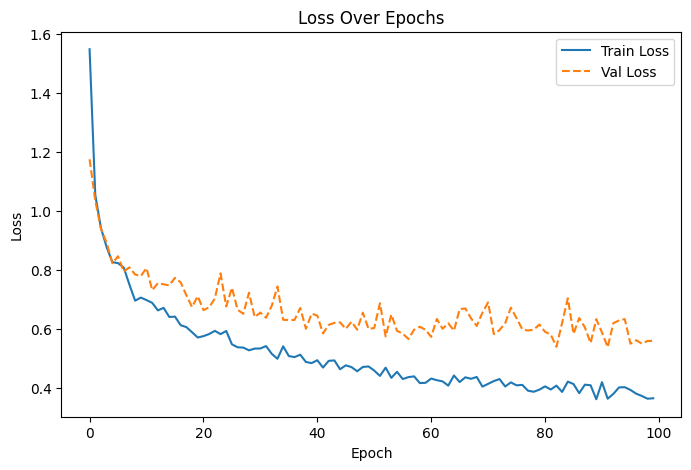

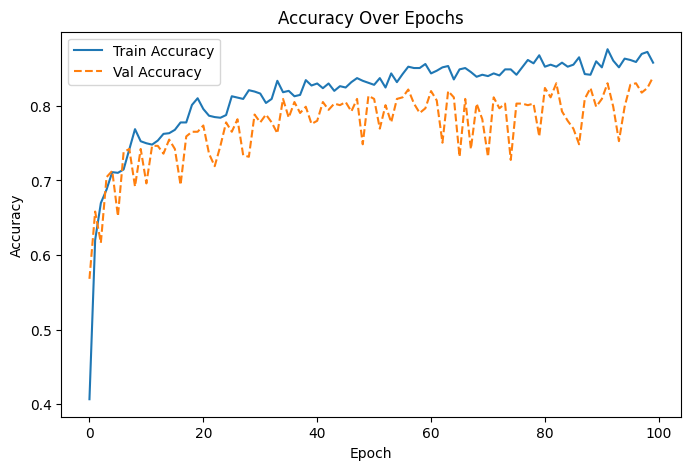

In [ ]:
################################################################################
# 14) OPTIONALLY: PLOT TRAINING CURVES
################################################################################

import pandas as pd # Import pandas for DataFrame

# Convert history to a DataFrame
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(8,5))
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

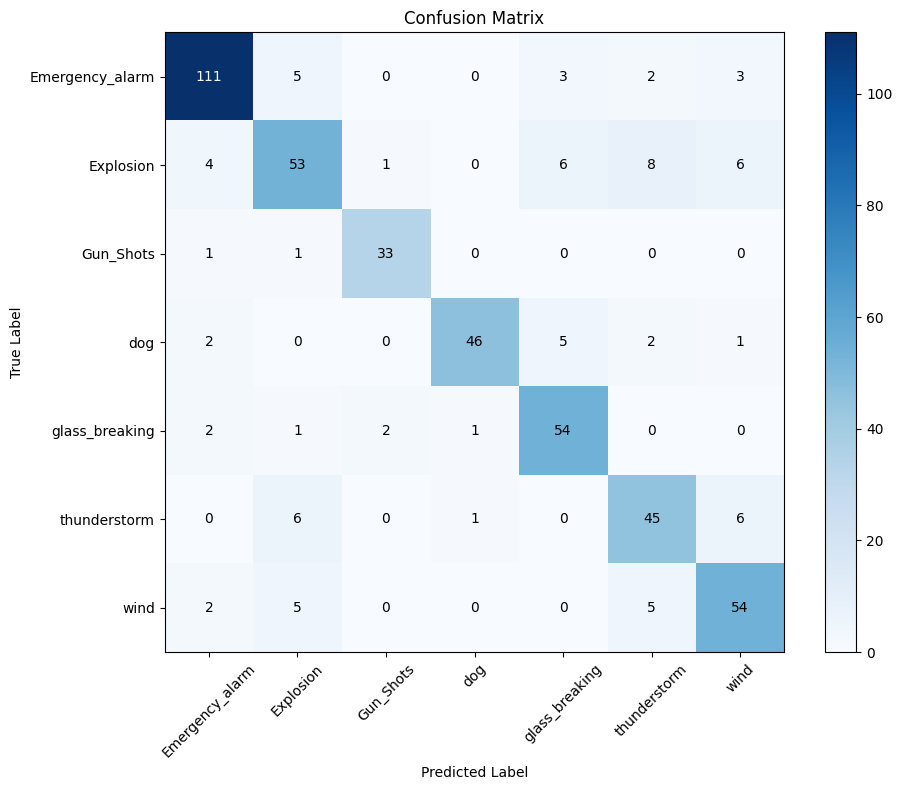

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Suppose you already have predictions (predicted_classes),
# ground truth classes (true_classes), and class labels (class_labels).
true_classes = test_generator.classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set tick labels (class names)
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Annotate each cell with the count
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        plt.text(j, i, str(value),
                 ha="center", va="center",
                 color="white" if value > threshold else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()  # Helps prevent label cutoff
plt.show()


In [ ]:
import pandas as pd

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping],
    shuffle=True
)

# Convert the training history to a DataFrame
df = pd.DataFrame(history.history)

# Save to CSV
csv_filename = '/content/drive/MyDrive/VGG19/MEL_Folder/training_metrics.csv'
df.to_csv(csv_filename, index=False)
print(f"Training metrics saved to {csv_filename}")

# Evaluate on test data
loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1_score)


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 696ms/step - accuracy: 0.8247 - f1_score_metric: 0.7792 - loss: 0.4585 - precision: 0.8644 - recall: 0.7848 - val_accuracy: 0.8155 - val_f1_score_metric: 0.1737 - val_loss: 0.5661 - val_precision: 0.8449 - val_recall: 0.7883
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 685ms/step - accuracy: 0.8854 - f1_score_metric: 0.8341 - loss: 0.3593 - precision: 0.9102 - recall: 0.8468 - val_accuracy: 0.8134 - val_f1_score_metric: 0.1723 - val_loss: 0.5750 - val_precision: 0.8552 - val_recall: 0.7925
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 671ms/step - accuracy: 0.8736 - f1_score_metric: 0.8201 - loss: 0.3894 - precision: 0.9103 - recall: 0.8268 - val_accuracy: 0.8365 - val_f1_score_metric: 0.1745 - val_loss: 0.5295 - val_precision: 0.8702 - val_recall: 0.8008
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 673ms/step - accuracy: 0.8577 - f1_score_metric: 0.8127 - loss: 0.3819 - precision: 0.9000 - recall: 0.8145 - val_accuracy: 0.8155 - val_f1_score_metric:

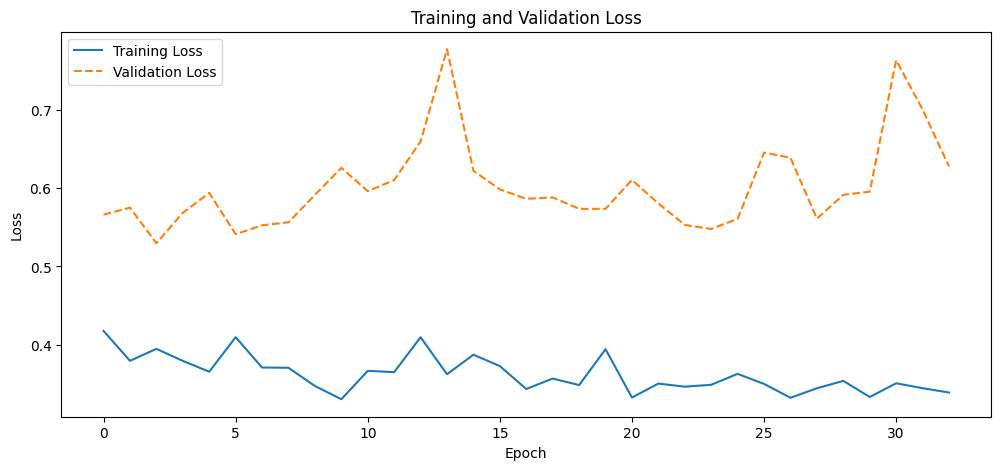

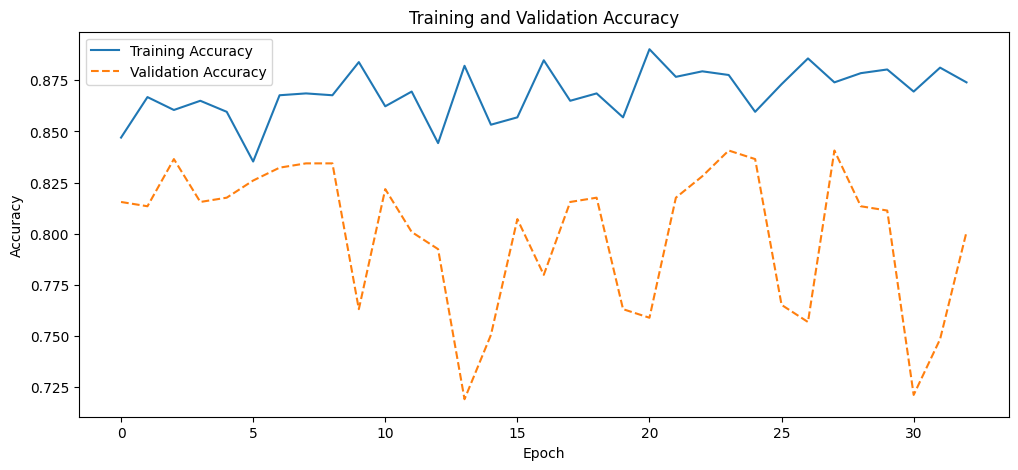

In [ ]:
import matplotlib.pyplot as plt

# Suppose your training run is stored in `history`
# after something like: history = model.fit(...)

# 1) Plot Training vs. Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2) Plot Training vs. Validation Accuracy
# (Only if 'accuracy' and 'val_accuracy' are in your history)
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.utils import register_keras_serializable

################################################################################
# 1) Define Your Custom F1 Metric (if used in training)
################################################################################

@register_keras_serializable()
def f1_score_metric(y_true, y_pred):
    # Round predictions to 0/1
    y_pred = tf.math.round(y_pred)

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall    = tp / (tp + fn + K.epsilon())
    f1        = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

################################################################################
# 2) Model & Data Configuration
################################################################################

num_classes = 7
height = 128
width = 128
channels = 3
batch_size = 32

model_path = '/content/drive/MyDrive/VGG19/MEL_Folder/al-emadi_vgg19_standardized_Mel_1_test.keras'
test_dir   = '/content/drive/MyDrive/ASE_Dataset_Folder/Mel_Images_1_Sec/Test/Sounds'

################################################################################
# 3) Load the Model with Custom Metric
################################################################################

model = tf.keras.models.load_model(
    model_path,
    custom_objects={'f1_score_metric': f1_score_metric}
)

################################################################################
# 4) Create Test Data Generator
################################################################################

test_datagen = ImageDataGenerator()  # No rescale=1./255?  Include if needed
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

################################################################################
# 5) Evaluate the Model
################################################################################

results = model.evaluate(test_generator)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

# If more metrics exist, print them
if len(results) > 2:
    print("Additional Metrics:")
    for metric, value in zip(model.metrics_names[2:], results[2:]):
        print(f"{metric.capitalize()}: {value:.4f}")

################################################################################
# 6) Predictions & Confusion Matrix
################################################################################

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("\nConfusion Matrix:")
print(conf_matrix)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

################################################################################
# 7) Classification Report
################################################################################

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

################################################################################
# 8) Per-Class Accuracy
################################################################################

class_accuracy = {}
for i, class_label in enumerate(class_labels):
    correct_indices = np.where(true_classes == i)[0]
    correct_predictions = np.sum(predicted_classes[correct_indices] == i)
    total_samples = len(correct_indices)
    if total_samples > 0:
        class_accuracy[class_label] = correct_predictions / total_samples
    else:
        class_accuracy[class_label] = 0.0

print("\nAccuracy for each class:")
for class_label in class_labels:
    print(f"{class_label}: {class_accuracy[class_label]:.4f}")


Found 477 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 391ms/step - accuracy: 0.5350 - f1_score_metric: 0.0944 - loss: 106.5778 - precision: 0.5350 - recall: 0.5350
Test Loss: 149.5158
Test Accuracy: 0.4130
Additional Metrics:
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 468ms/step

Confusion Matrix:
[[93  0  0  1 30  0  0]
 [16  0  0  3 59  0  0]
 [ 9  0  0  0 26  0  0]
 [ 4  0  0 43  9  0  0]
 [ 0  0  0  1 59  0  0]
 [27  0  0  5 24  2  0]
 [41  0  0  0 24  1  0]]

Classification Report:
                 precision    recall  f1-score   support

Emergency_alarm       0.49      0.75      0.59       124
      Explosion       0.00      0.00      0.00        78
      Gun_Shots       0.00      0.00      0.00        35
            dog       0.81      0.77      0.79        56
 glass_breaking       0.26      0.98      0.41        60
   thunderstorm       0.67      0.03      0.07        58
           wind       0.00      0.00      0.00        66

       accuracy                           0.41       477
      macro avg       0.32   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


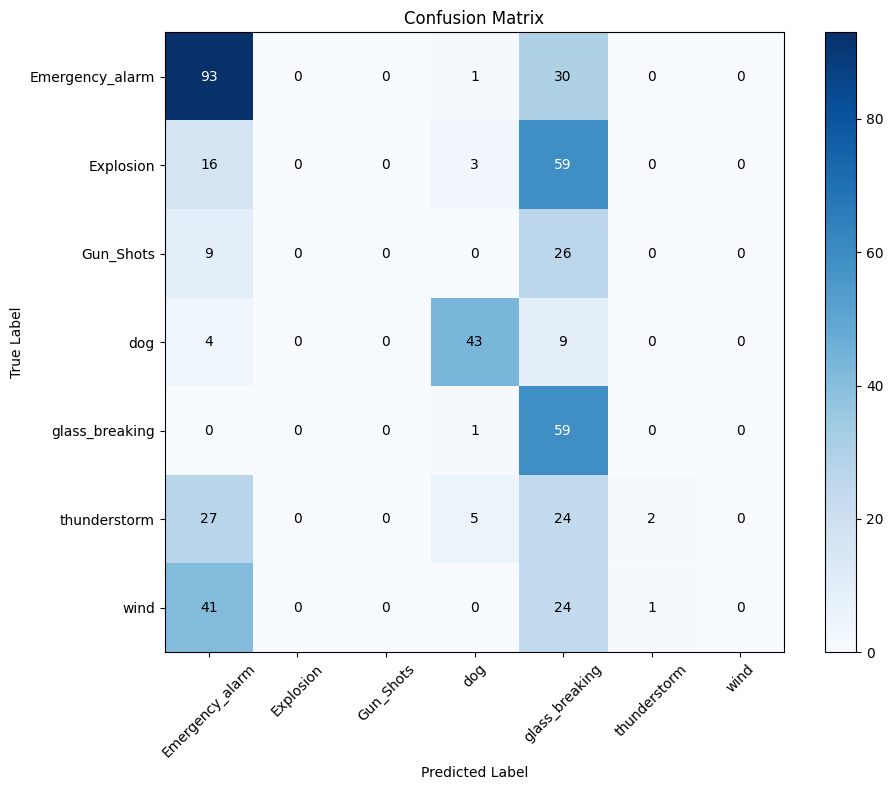

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Suppose you already have predictions (predicted_classes),
# ground truth classes (true_classes), and class labels (class_labels).
true_classes = test_generator.classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set tick labels (class names)
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Annotate each cell with the count
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        plt.text(j, i, str(value),
                 ha="center", va="center",
                 color="white" if value > threshold else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()  # Helps prevent label cutoff
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

# Load the pre-trained model
model_path = '/content/drive/MyDrive/VGG19/Mel_Folder/al-emadi_vgg19_standardized_Mel_1_test.keras'
model = tf.keras.models.load_model(model_path)

# Data dimensions
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1

hop_size_sec = hop_length / sr
audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)
channels = 3
batch_size = 32

# Configuration for prediction
predict_datagen = ImageDataGenerator()
predict_dir = '/content/drive/MyDrive/TEST'  # Update this path to your directory

predict_generator = predict_datagen.flow_from_directory(
    predict_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode=None,  # No labels are provided
    shuffle=False)  # Important for maintaining order

# Ensure the generator is not empty
if len(predict_generator) == 0:
    raise ValueError(f"Predict generator is empty. Check the directory: {predict_dir}, ensure images are in a subfolder and 'target_size' is correct.")

# Make predictions
predictions = model.predict(predict_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get filenames from the generator
filenames = predict_generator.filenames

# Assuming you have a mapping of class indices to class labels
class_labels = {0: "Emergency_alarm", 1: "Explosion", 2: "Gun_Shots"}  # Update as per your model classes

# Zip filenames with predicted classes and labels
predicted_labels = [class_labels[cls] for cls in predicted_classes]
results = zip(filenames, predicted_classes, predicted_labels)

# Print results
print("Filename, Predicted Class ID, Predicted Label:")
for filename, class_id, label in results:
    print(f"{filename}, {class_id}, {label}")
